In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from random import sample, randrange
from collections import Counter
from statistics import mean

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, scale
from sklearn.model_selection import train_test_split,GridSearchCV,KFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report,roc_curve, roc_auc_score, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer

import pyrepseq as prs
import pyrepseq.plotting as rsp
import pyrepseq.distance as rsd
import pyrepseq.stats as rss

from Levenshtein import hamming as hamming_distance
from Levenshtein import distance as levenshtein_distance

In [2]:
%run "Functions.ipynb"

In [3]:
all_seqs = pd.read_csv('CDR3B_sequences.csv',sep=',',on_bad_lines='skip',header =0)

In [4]:
all_seqs

,CDR3,Chain Length,Epitope
0,CASSQDLSRLASYEQYF,17,Background
1,CASSEIGIQPQHF,13,Background
2,CSVEDHGSYNEQFF,14,Background
3,CATSSLAGVETQYF,14,Background
4,CASSQGQGARENIQYF,16,Background
...,...,...,...
43708,CATQDMNTGELFF,13,YLQPRTFLL
43709,CASLLKLRDTSYEQYF,16,YLQPRTFLL
43710,CSVMDSLNTGELFF,14,YLQPRTFLL
43711,CASQQGNTGELFF,13,YLQPRTFLL


In [5]:
BG,KLG,NLV,GIL,AVF,ELA,GLC,YLQ,RAK = (all_seqs.loc[(all_seqs['Epitope'] == 'Background')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'KLGGALQAK')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'NLVPMVATV')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'GILGFVFTL')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'AVFDRKSDAK')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'ELAGIGILTV')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'GLCTLVAML')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'YLQPRTFLL')],
                          all_seqs.loc[(all_seqs['Epitope'] == 'RAKFKQLL')]
                         )

## Finding k-nearest neighbours

## YLQ and GIL epitopes

In [7]:
GIL_samp = GIL.sample(len(YLQ), random_state=1)
print(f"Starting sizes: GIL(sampled): {len(GIL_samp)} seqs, YLQ: {len(YLQ)} seqs.\n")

YLQ_GIL = pd.concat([GIL.sample(len(YLQ), random_state=1),YLQ])

YLQ_train, YLQ_test = train_test_split(YLQ, test_size = 0.15, random_state = 1)
GIL_train, GIL_test= train_test_split(GIL_samp, test_size = 0.15, random_state = 1)

print(f"(per epitope) Number of training seqs: {len(GIL_train)}, testing seqs: {len(GIL_test)}, ({len(GIL_test)/(len(GIL_train)+len(GIL_test))*100:.1f} % for testing) ")
print(f"(Total) Number of training seqs: {len(GIL_train)+len(YLQ_train)}, testing seqs: {len(GIL_test)+len(YLQ_test)}, ({(len(GIL_test)+len(YLQ_test))/(len(GIL_train)+len(GIL_test)+len(YLQ_train)+len(YLQ_test))*100:.1f} % for testing) ")

Starting sizes: GIL(sampled): 897 seqs, YLQ: 897 seqs.

(per epitope) Number of training seqs: 762, testing seqs: 135, (15.1 % for testing) 
(Total) Number of training seqs: 1524, testing seqs: 270, (15.1 % for testing) 


In [8]:
YLQ_GIL_test = pd.concat([YLQ_test, GIL_test])
x_test = YLQ_GIL_test['CDR3'].to_numpy()
y_test = YLQ_GIL_test['Epitope'].to_numpy()

In [9]:
YLQ_GIL_train = pd.concat([YLQ_train, GIL_train])
x_train = YLQ_GIL_train['CDR3'].to_numpy()
y_train = YLQ_GIL_train['Epitope'].to_numpy()

k=1 	 Accuracy = 0.755556
k=3 	 Accuracy = 0.781481
k=5 	 Accuracy = 0.781481
k=7 	 Accuracy = 0.755556
k=9 	 Accuracy = 0.774074
k=11 	 Accuracy = 0.770370
k=13 	 Accuracy = 0.759259
k=15 	 Accuracy = 0.766667
k=17 	 Accuracy = 0.766667
k=19 	 Accuracy = 0.774074


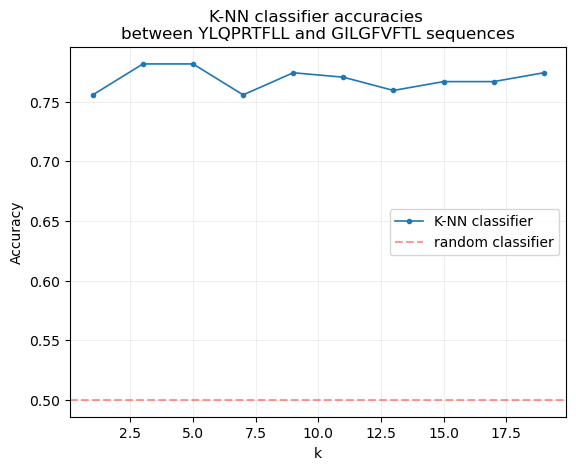

In [10]:
test_neighbours_no = np.arange(1,21,2)

knn_tts_accs =[]

for k in test_neighbours_no:
    train_test_split_acc, y_predictions = KNN(x_train, x_test, y_train, y_test,k)
    knn_tts_accs.append(train_test_split_acc)

    print(f"k={k} \t Accuracy = {train_test_split_acc:.6f}")

plt.figure()
plt.grid(alpha=0.2)
plt.title(f"K-NN classifier accuracies \nbetween YLQPRTFLL and GILGFVFTL sequences")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(test_neighbours_no,knn_tts_accs,'.-',label='K-NN classifier', linewidth=1.2)
plt.axhline(y = 0.5, color = 'r', linestyle = '--',label = 'random classifier', alpha = 0.4)
plt.legend()    
plt.savefig('Figures/KNN_acc.jpg')
plt.show()

### Aligned Sequences

In [11]:
global_alg_length = 21

YLQ_GIL_test_alg = lr_align(YLQ_GIL_test,showmaxlength=False, set_maxlength = 25,global_maxlength = global_alg_length, include_local = False)
print(YLQ_GIL_test_alg)

YLQ_GIL_train_alg = lr_align(YLQ_GIL_train,showmaxlength=False, set_maxlength = 25,global_maxlength = global_alg_length, include_local = False)
print(YLQ_GIL_train_alg)

         Epitope  Old length              Glob lalg              Glob ralg  \
42900  YLQPRTFLL          16  CAIQDRGSLNTGELFF-----  -----CAIQDRGSLNTGELFF   
43518  YLQPRTFLL          13  CAVQDSNTGELFF--------  --------CAVQDSNTGELFF   
42958  YLQPRTFLL          16  CSARDRVGQNTGELFF-----  -----CSARDRVGQNTGELFF   
43611  YLQPRTFLL          13  CATQNMNTGELFF--------  --------CATQNMNTGELFF   
43561  YLQPRTFLL          13  CATQRANTGELFF--------  --------CATQRANTGELFF   
...          ...         ...                    ...                    ...   
31406  GILGFVFTL          13  CASSQRSSDTQYF--------  --------CASSQRSSDTQYF   
32640  GILGFVFTL          13  CASSIFGQVDAFF--------  --------CASSIFGQVDAFF   
32705  GILGFVFTL          13  CASSPRSGNTIYF--------  --------CASSPRSGNTIYF   
33197  GILGFVFTL          15  CASSADGILNTEAFF------  ------CASSADGILNTEAFF   
31392  GILGFVFTL          17  CASSLLAGGSGTDTQYF----  ----CASSLLAGGSGTDTQYF   

       Glob alg length  
42900               21  
43518        

In [12]:
lx_test = YLQ_GIL_test_alg['Glob lalg'].to_numpy()
rx_test = YLQ_GIL_test_alg['Glob ralg'].to_numpy()

ly_test = YLQ_GIL_test_alg['Epitope'].to_numpy()
ry_test = YLQ_GIL_test_alg['Epitope'].to_numpy()

lx_train = YLQ_GIL_train_alg['Glob lalg'].to_numpy()
rx_train = YLQ_GIL_train_alg['Glob ralg'].to_numpy()

ly_train = YLQ_GIL_train_alg['Epitope'].to_numpy()
ry_train = YLQ_GIL_train_alg['Epitope'].to_numpy()

k=1 	 (L) Accuracy = 0.766667 	 (R) Accuracy = 0.766667
k=3 	 (L) Accuracy = 0.770370 	 (R) Accuracy = 0.766667
k=5 	 (L) Accuracy = 0.766667 	 (R) Accuracy = 0.766667
k=7 	 (L) Accuracy = 0.766667 	 (R) Accuracy = 0.770370
k=9 	 (L) Accuracy = 0.796296 	 (R) Accuracy = 0.796296
k=11 	 (L) Accuracy = 0.785185 	 (R) Accuracy = 0.785185
k=13 	 (L) Accuracy = 0.803704 	 (R) Accuracy = 0.803704
k=15 	 (L) Accuracy = 0.792593 	 (R) Accuracy = 0.788889
k=17 	 (L) Accuracy = 0.788889 	 (R) Accuracy = 0.785185
k=19 	 (L) Accuracy = 0.796296 	 (R) Accuracy = 0.800000


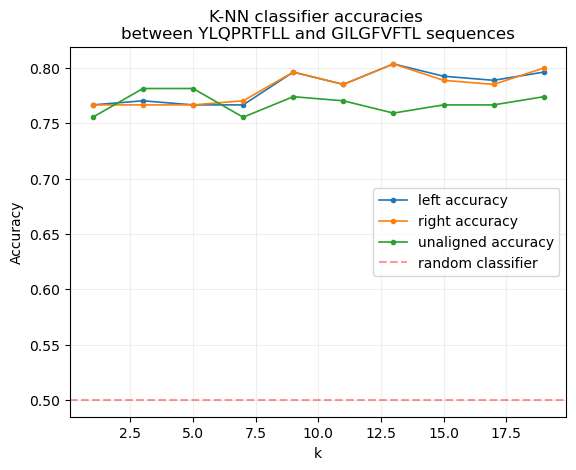

In [13]:
test_neighbours_no = np.arange(1,21,2)

l_knn_tts_accs =[]
r_knn_tts_accs =[]

for k in test_neighbours_no:
    l_train_test_split_acc, l_y_predictions = KNN(lx_train, lx_test, ly_train, ly_test,k)
    l_knn_tts_accs.append(l_train_test_split_acc)

    r_train_test_split_acc, r_y_predictions = KNN(rx_train, rx_test, ry_train, ry_test,k)
    r_knn_tts_accs.append(r_train_test_split_acc)    
    print(f"k={k} \t (L) Accuracy = {l_train_test_split_acc:.6f} \t (R) Accuracy = {r_train_test_split_acc:.6f}")

plt.figure()
plt.grid(alpha=0.2)
plt.title(f"K-NN classifier accuracies \nbetween YLQPRTFLL and GILGFVFTL sequences")
plt.xlabel("k")
plt.ylabel("Accuracy")
plt.plot(test_neighbours_no,l_knn_tts_accs,'.-',label='left accuracy', linewidth=1.2)
plt.plot(test_neighbours_no,r_knn_tts_accs,'.-',label='right accuracy', linewidth=1.2)
plt.plot(test_neighbours_no,knn_tts_accs,'.-',label='unaligned accuracy', linewidth=1.2)

plt.axhline(y = 0.5, color = 'r', linestyle = '--',label = 'random classifier', alpha = 0.4)
plt.legend()    
plt.savefig('Figures/KNN_acc_with_aligned.jpg')
plt.show()

### KLG and GIL epitopes

Total sequences (KLG-GIL): 6938.
k=1 		 train_test_split accuracy = 0.591499
k=3 		 train_test_split accuracy = 0.596542
k=5 		 train_test_split accuracy = 0.600144
k=7 		 train_test_split accuracy = 0.594380
k=9 		 train_test_split accuracy = 0.612392
k=11 		 train_test_split accuracy = 0.608790
k=13 		 train_test_split accuracy = 0.618156
k=15 		 train_test_split accuracy = 0.610231
k=17 		 train_test_split accuracy = 0.610951
k=19 		 train_test_split accuracy = 0.615994


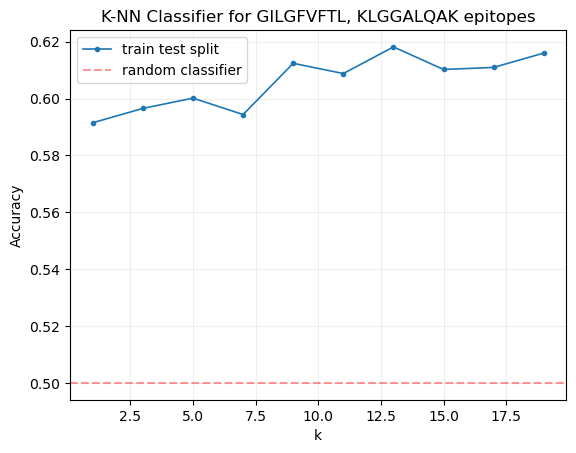

In [14]:
KLG_GIL = pd.concat([KLG.sample(len(GIL), random_state=1),GIL]) # compare just the KLG and GIL epitopes, make the sizes the same
print(f"Total sequences (KLG-GIL): {len(KLG_GIL)}.")

x_train, x_test, y_train, y_test = train_test_split(KLG_GIL['CDR3'], KLG_GIL['Epitope'], test_size = 0.2, random_state = 1)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

plot_KNN_accs(KLG_GIL, test_neighbours_no = np.arange(1,21,2), cv_show = False, n_iter = 1, test_rat = 0.2, rand_state = 1)

### KLG and NLV epitopes

Total sequences (NLV-KLG): 9244.
k=1 		 train_test_split accuracy = 0.539751
k=3 		 train_test_split accuracy = 0.534884
k=5 		 train_test_split accuracy = 0.531098
k=7 		 train_test_split accuracy = 0.518659
k=9 		 train_test_split accuracy = 0.524608
k=11 		 train_test_split accuracy = 0.538670
k=13 		 train_test_split accuracy = 0.538129
k=15 		 train_test_split accuracy = 0.550027
k=17 		 train_test_split accuracy = 0.552731
k=19 		 train_test_split accuracy = 0.550027


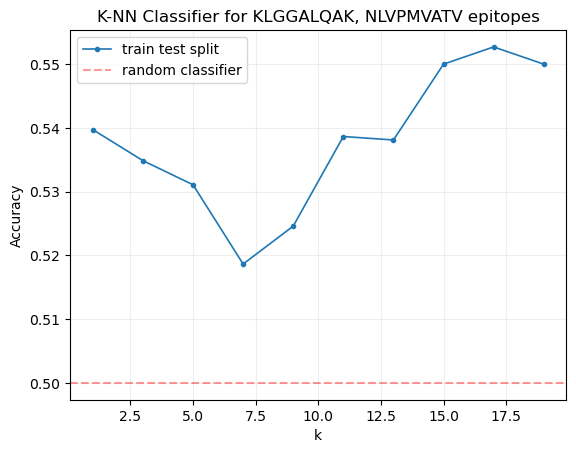

In [15]:
NLV_KLG = pd.concat([KLG.sample(len(NLV), random_state=1),NLV]) # compare just the KLG and GIL epitopes, make the sizes the same
print(f"Total sequences (NLV-KLG): {len(NLV_KLG)}.")

x_train, x_test, y_train, y_test = train_test_split(NLV_KLG['CDR3'], NLV_KLG['Epitope'], test_size = 0.2, random_state = 1)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

plot_KNN_accs(NLV_KLG, test_neighbours_no = np.arange(1,21,2), cv_show = False, n_iter = 1, test_rat = 0.2, rand_state = 1)